# RL and Advanced DL: Домашнее задание 2

- Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, **в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
import random
import itertools

from copy import deepcopy
from collections import Counter, defaultdict

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces
from gym.utils import seeding
from torch.autograd import Variable
from IPython.display import clear_output
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны:

**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win  
            self.reset()
            self.rand_state = 0
            self.len_board = n_rows
            self.actions = self.getEmptySpaces().tolist()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()
    
    def random_step(self, action):
        state, reward, done, _ = self.step(self.actions[action])
        self.rand_state += 1
        
        if not done:
            action_random = self.getEmptySpaces()
            _, _, done, _ = self.step(random.choice(action_random))
            self.rand_state += 1
            if done:
                return self.board, -1, True
            else:
                return self.board, 0, False
        else:
            if reward == -10:
                return self.board, -10, True
            else:
                if self.rand_state == self.len_board * self.len_board:
                    return self.board, -0.5, True
                else:
                    return self.board, 1, True
        
    def reset_rand(self):
        self.rand_state = 0
        self.reset()
        return self.board, 0, False

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            print("Крестики выиграли!")
        if reward == -1:
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            print("Нолики выиграли!")

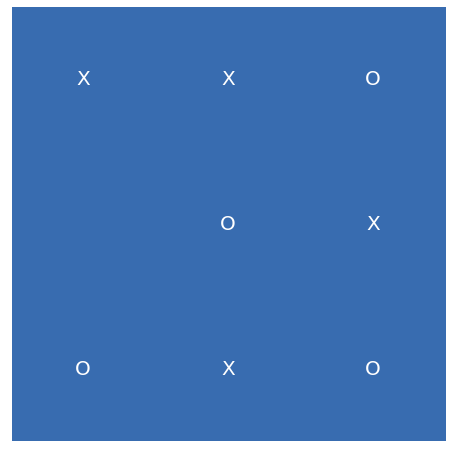

Нолики выиграли!


In [6]:
env = TicTacToe()
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

In [7]:
def update_func(alpha, gamma, q_function, state, action, rewards, next_state=None):
    if next_state is not None:
        next_state = np.max(q_function[next_state])
    else:
        next_state = 0 
    return q_function[state][action] + alpha * (rewards + gamma * next_state - q_function[state][action])

def rolling_window(rewards, window):
    len_board = rewards.shape[:-1] + (rewards.shape[-1] - window + 1, window)
    strides = rewards.strides + (rewards.strides[-1],)
    return np.lib.stride_tricks.as_strided(rewards, shape=len_board, strides=strides)

def get_index(actions, action):
    if action in actions:
        return actions.index(action)
    return -1

def q_learning(env, alpha, gamma, epsilon, episodes, len_board):
    rewards = []
    rew = 0
    rewards_mean = []
    env.reset()
    list_actions = env.getEmptySpaces().tolist()
    
    q_table_state = defaultdict(lambda: np.random.uniform(size=len_board*len_board).tolist())
    for i in tqdm(range(1, episodes)):
        state = env.reset()
        reward = 0
        done = False
        new_actions, new_states = [], []
        
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == -1:
                action = random.choice(actions)
            else:
                while True:
                    if random.random() > epsilon:
                        action = list_actions[np.argmax(q_table_state[state[0]])]
                    else:
                        action = random.choice(list_actions)
                    if action not in actions:
                        prev = get_index(list_actions, action)
                        q_table_state[state[0]][prev] = -1000
                    else:
                        break
                new_actions.append(action)
            next_state, reward, done, _ = env.step(action) 
            
            if done == False:
                reward = 0
            else:
                if env.curTurn == -1:
                    reward = 1
                else:
                    reward = -1
                prev_state = new_states[-1]
                prev_action = get_index(list_actions, new_actions[-1])
                q_table_state[prev_state][prev_action] = update_func(
                    alpha, gamma, q_table_state, prev_state, prev_action, reward, next_state[0]
                )
                state = next_state
            
            if env.curTurn == 1:
                prev_state = state[0]
                prev_action = get_index(list_actions, new_actions[-1])
                new_states.append(prev_state)
                q_table_state[prev_state][prev_action] = update_func(
                    alpha, gamma, q_table_state, prev_state, prev_action, reward, next_state[0]
                )
                state = next_state

        rewards.append(reward)
        rew += reward
        rewards_mean.append(rew / i)
        
        if i % 10000 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(16, 8))
            plt.plot(np.mean(rolling_window(np.array(rewards), 500), 1))
            plt.xlabel('Эпизоды обучения')
            plt.ylabel('Награда')
            plt.show()
            plt.close()
    return rewards_mean

def plot_mean_rewards(rewards):
    plt.figure(figsize=(16, 8))
    plt.plot(rewards)
    plt.xlabel('Эпизоды обучения')
    plt.ylabel('Награда')
    plt.show()
    print("Средняя награда", np.mean(rewards))

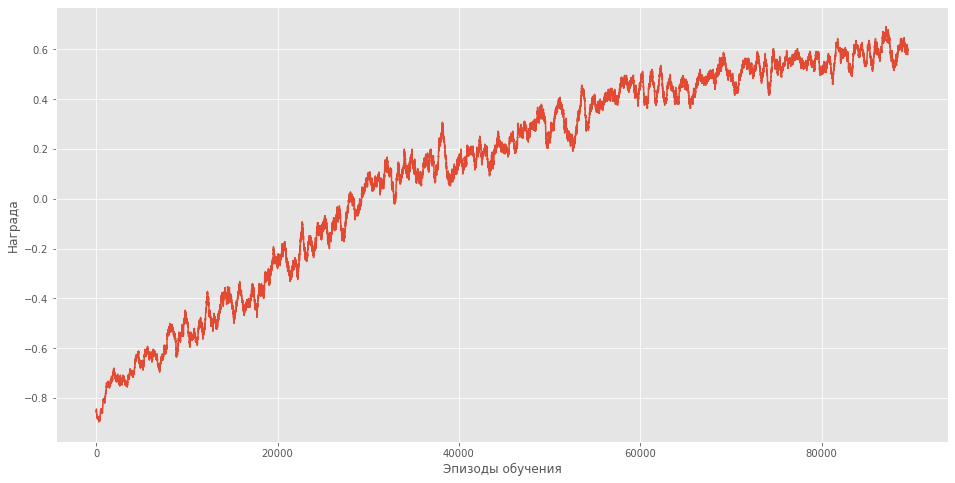

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:46<00:00, 2169.49it/s]


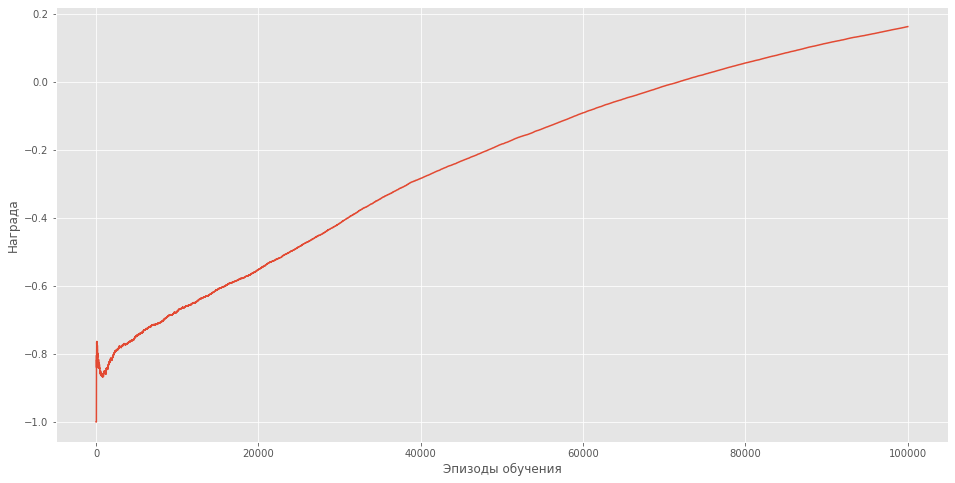

Средняя награда -0.23703821718623316


In [8]:
len_board = 3
env = TicTacToe(len_board, len_board, len_board)

alpha, gamma, epsilon = 0.005, 0.95, 0.003
rewards = q_learning(env, episodes=100000, alpha=alpha, gamma=gamma, epsilon=epsilon, len_board=len_board)
plot_mean_rewards(rewards)

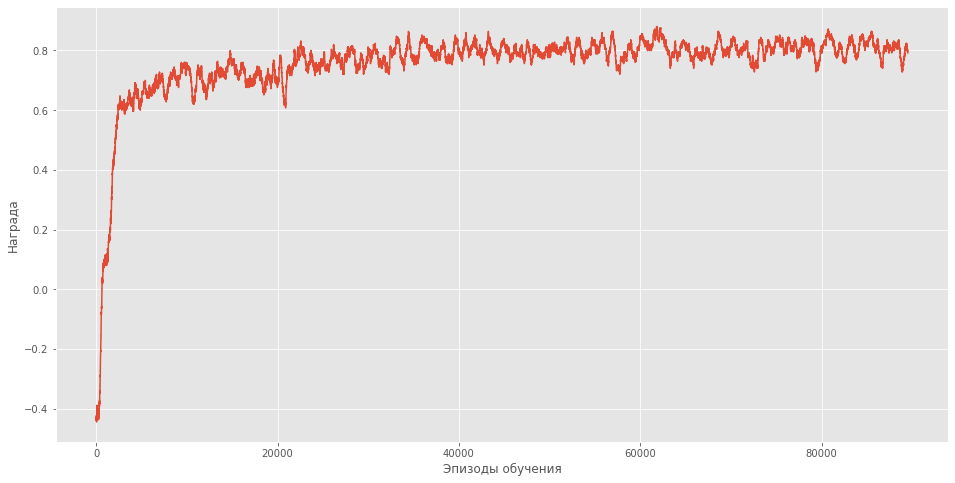

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:38<00:00, 2572.95it/s]


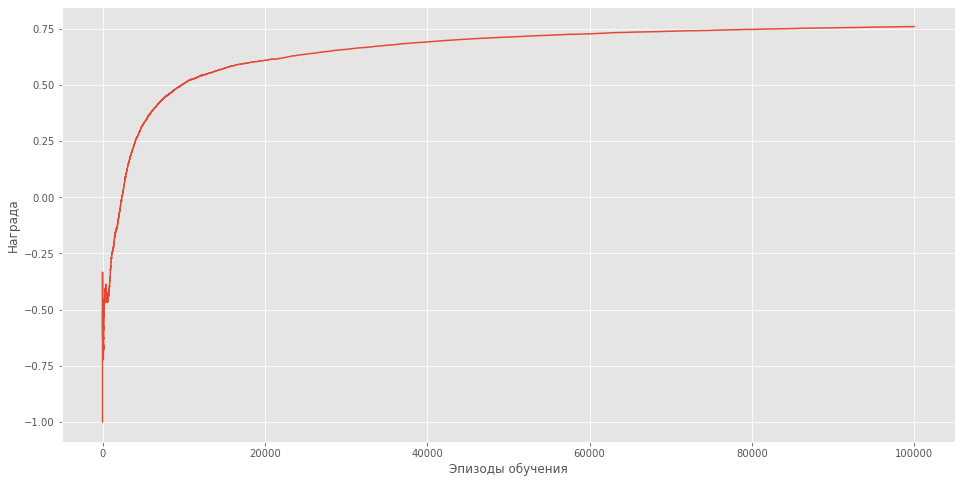

Средняя награда 0.6490910960331436


In [9]:
len_board = 3
env = TicTacToe(len_board, len_board, len_board)

alpha, gamma, epsilon = 0.2, 0.9, 0.04
rewards = q_learning(env, episodes=100000, alpha=alpha, gamma=gamma, epsilon=epsilon, len_board=len_board)
plot_mean_rewards(rewards)

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

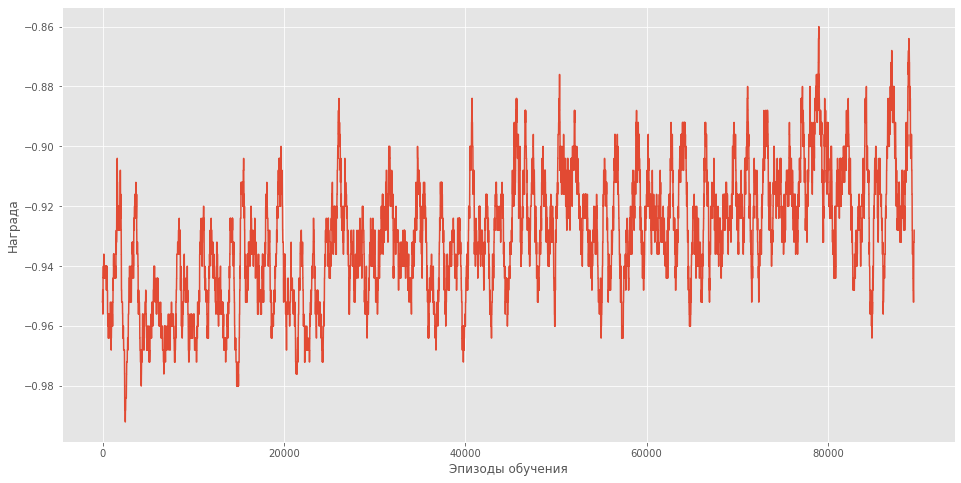

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [01:09<00:00, 1430.93it/s]


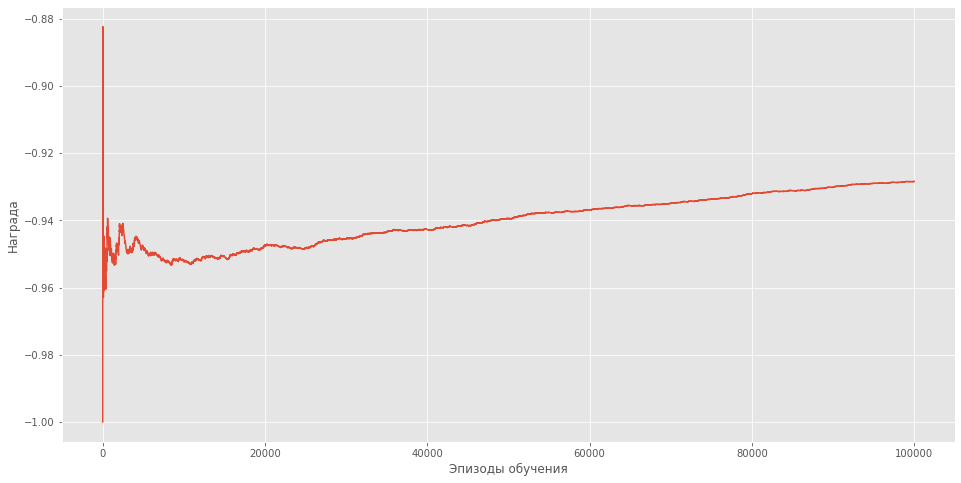

Средняя награда -0.9399689817483152


In [11]:
len_board = 4
env = TicTacToe(len_board, len_board, len_board)

alpha, gamma, epsilon = 0.005, 0.95, 0.003
rewards = q_learning(env, episodes=100000, alpha=alpha, gamma=gamma, epsilon=epsilon, len_board=len_board)
plot_mean_rewards(rewards)

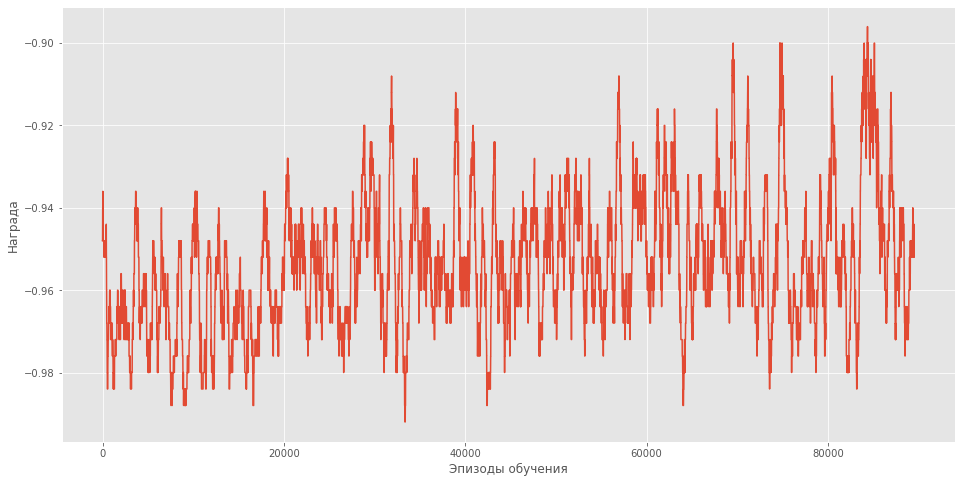

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [01:08<00:00, 1449.37it/s]


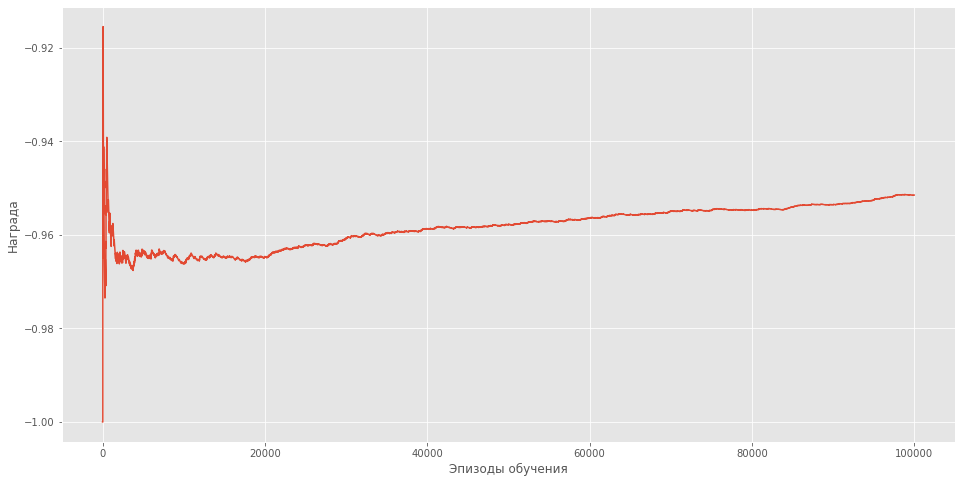

Средняя награда -0.9583376678680141


In [12]:
len_board = 4
env = TicTacToe(len_board, len_board, len_board)

alpha, gamma, epsilon = 0.2, 0.9, 0.04
rewards = q_learning(env, episodes=100000, alpha=alpha, gamma=gamma, epsilon=epsilon, len_board=len_board)
plot_mean_rewards(rewards)

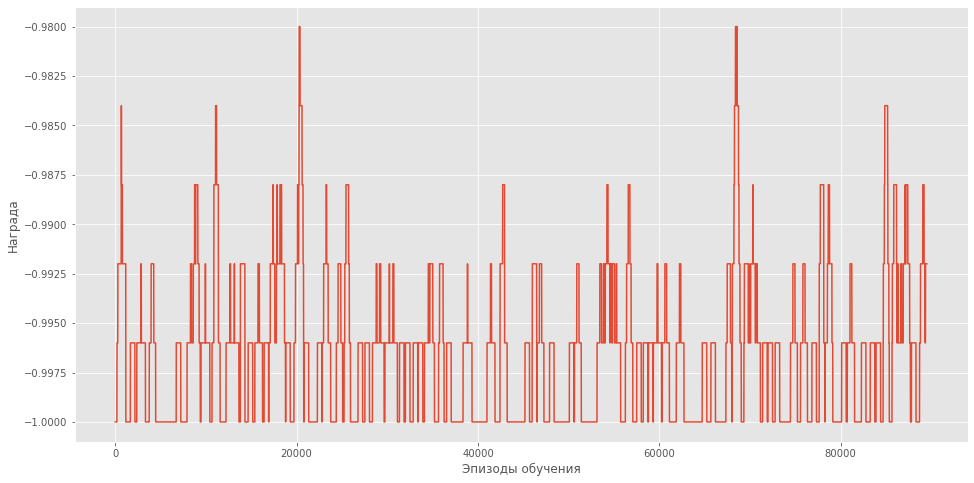

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [01:38<00:00, 1019.53it/s]


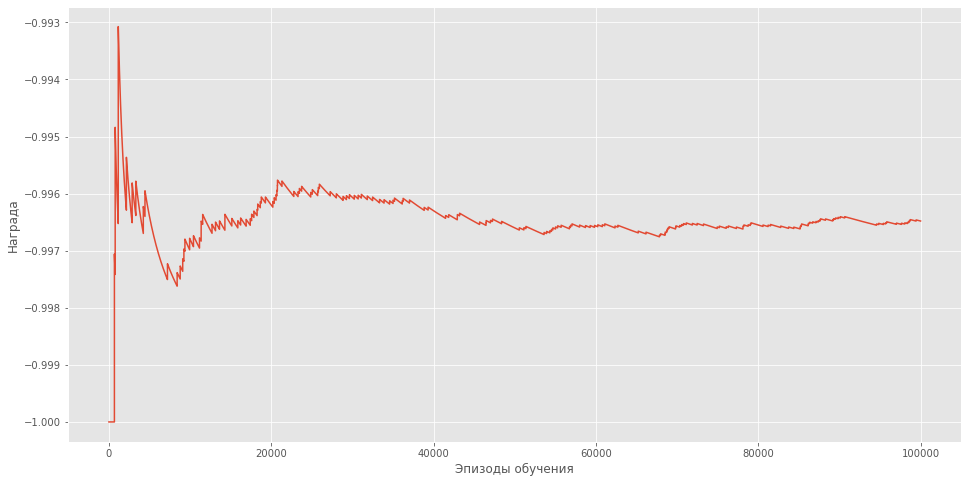

Средняя награда -0.996470602796205


In [13]:
len_board = 5
env = TicTacToe(len_board, len_board, len_board)

alpha, gamma, epsilon = 0.005, 0.95, 0.003
rewards = q_learning(env, episodes=100000, alpha=alpha, gamma=gamma, epsilon=epsilon, len_board=len_board)
plot_mean_rewards(rewards)

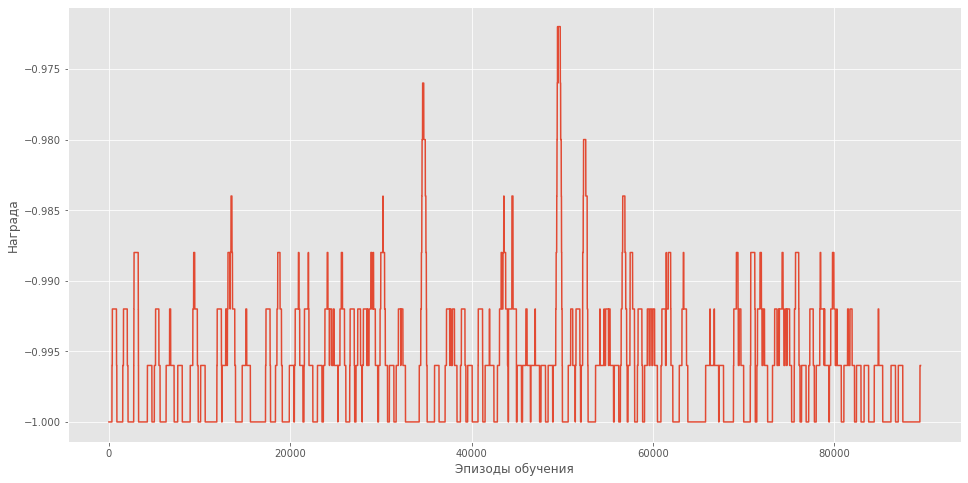

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [01:30<00:00, 1105.30it/s]


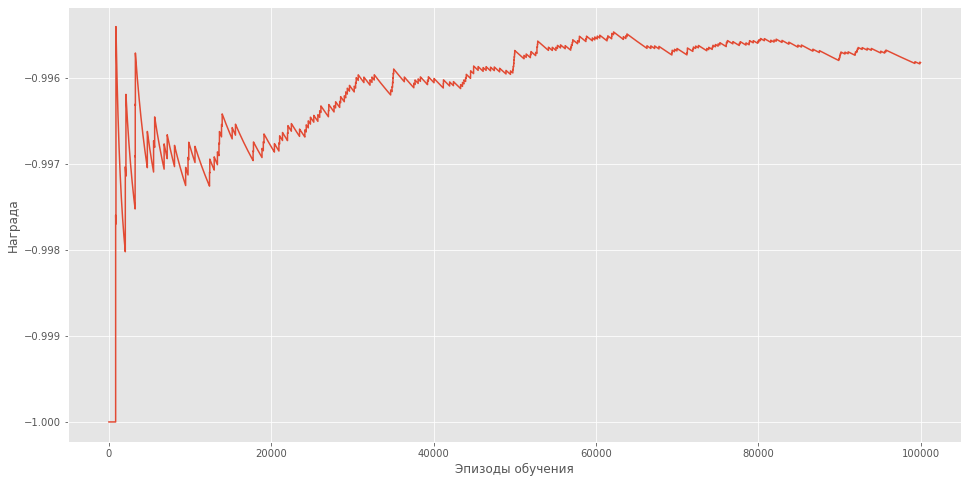

Средняя награда -0.9960655884056221


In [14]:
len_board = 5
env = TicTacToe(len_board, len_board, len_board)

alpha, gamma, epsilon = 0.2, 0.9, 0.04
rewards = q_learning(env, episodes=100000, alpha=alpha, gamma=gamma, epsilon=epsilon, len_board=len_board)
plot_mean_rewards(rewards)

#### Вывод:

Q-обучение с эпсилон-жадной стратегией отлично справляется с игрой крестики-нолики на доске 3х3 после подбора гиперпараметров, но при увеличении доски становится всё хуже. Так при игре на доске 4х4 еще можно достичь результатов при большем количестве игр и лучших параметрах, но на доске 5х5 уже невозможно выиграть.

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше):

### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [15]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def save(self, memor):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = memor
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, len_board, pad=1, conv_len=32):
        self.len_board = len_board
        nn.Module.__init__(self)
        self.c1 = torch.nn.Conv2d(1, conv_len, len_board, padding=(pad, pad))
        self.c2 = torch.nn.Conv2d(conv_len, 3, len_board, padding=(pad, pad))
        self.lr = nn.Linear(len_board * len_board * 3, len_board * len_board)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.relu(self.c2(x))
        x = self.lr(x.view(-1, self.len_board * self.len_board * 3))
        return x

In [16]:
class TicTacToeDQN():
    def __init__(self, len_board, pad=1, batch_size=64):
        self.len_board = len_board
        self.env = TicTacToe(self.len_board, self.len_board, self.len_board)
        self.model = DQN(len_board, pad)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 1e-3)
        self.batch_size = batch_size
        self.rewards = []
        self.rewards_mean = []
        
    def state_torch(self, state):
        return torch.tensor(state, dtype=torch.float32).reshape(1, 1, self.len_board, self.len_board)
        
    def learn_model(self):
        state, reward, done = self.env.reset_rand()
        while True:
            to_state = self.state_torch(state)
            with torch.no_grad():
                action = self.model(to_state).data.max(1)[1].view(1, 1)
                    
            next_state, reward, done = self.env.random_step(action.numpy()[0][0])
            next_state_tensor = self.state_torch(next_state)
            transition = (to_state, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.save(transition)
            if len(self.memory) < self.batch_size:
                return

            transitions = self.memory.sample(self.batch_size)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
            batch_state = Variable(torch.cat(batch_state))
            batch_action = Variable(torch.cat(batch_action))
            batch_reward = Variable(torch.cat(batch_reward))
            batch_next_state = Variable(torch.cat(batch_next_state))

            q_model = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
            q_max = self.model(batch_next_state).detach().max(1)[0]
            q_next = batch_reward + (0.8 * q_max)
            
            loss = F.smooth_l1_loss(q_model, q_next)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            state = next_state
            if done:
                self.rewards.append(reward)
                break

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:54<00:00, 87.23it/s]


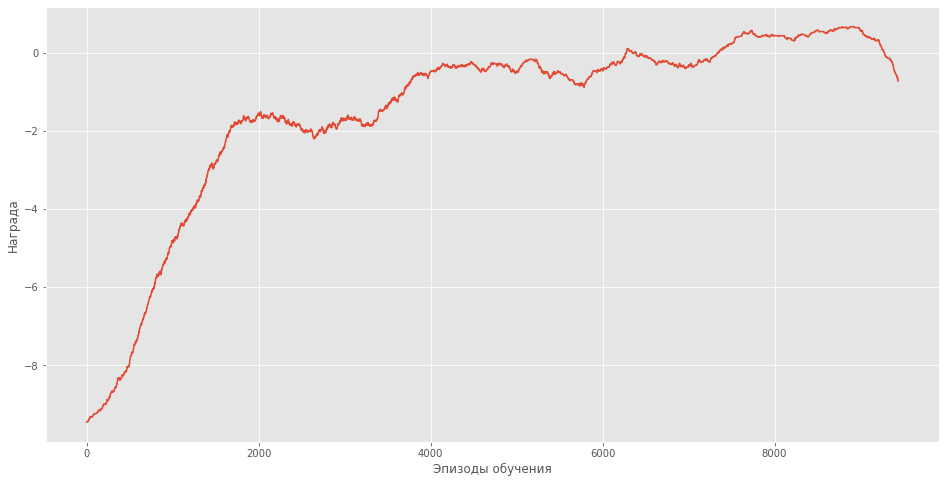

Средняя награда -1.6689141592029788


In [17]:
env = TicTacToeDQN(3)
for _ in tqdm(range(10000)):
    env.learn_model()
    
plt.figure(figsize=(16, 8))
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.plot(np.mean(rolling_window(np.array(env.rewards), 500), 1))
plt.show()
print("Средняя награда", np.mean(env.rewards))

### 4. Реализуйте Double DQN и/или Dueling DQN.

In [20]:
class DuelingDQN(nn.Module):
    def __init__(self, len_board):
        super(DuelingDQN, self).__init__()
        self.len_board = len_board
        self.conv = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc_layer = self.conv(torch.zeros(1, 1, self.len_board, self.len_board)).view(1, -1).size(1)
        self.layer1 = nn.Sequential(
            nn.Linear(self.fc_layer, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(self.fc_layer, 128),
            nn.ReLU(),
            nn.Linear(128, self.len_board * self.len_board)
        )

    def forward(self, state):
        x = self.conv(state)
        x = x.view(x.size(0), -1)
        x = self.layer1(x) + (self.layer2(x) - self.layer2(x).mean())
        return x

In [21]:
class TicTacToeDuelingDQN():
    def __init__(self, len_board, batch_size=64):
        self.len_board = len_board
        self.env = TicTacToe(self.len_board, self.len_board, self.len_board)
        self.model = DuelingDQN(len_board)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.batch_size = batch_size
        self.rewards = []
        
    def state_torch(self, state):
        return torch.tensor(state, dtype=torch.float32).reshape(1, 1, self.len_board, self.len_board)
        
    def learn_model(self):
        state, reward, done = self.env.reset_rand()
        while True:
            to_state = self.state_torch(state)
            with torch.no_grad():
                action = self.model(to_state).data.max(1)[1].view(1, 1)
                    
            next_state, reward, done = self.env.random_step(action.numpy()[0][0])
            next_state_tensor = self.state_torch(next_state)
            transition = (to_state, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.save(transition)
            if len(self.memory) < self.batch_size:
                return

            transitions = self.memory.sample(self.batch_size)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
            batch_state = Variable(torch.cat(batch_state))
            batch_action = Variable(torch.cat(batch_action))
            batch_reward = Variable(torch.cat(batch_reward))
            batch_next_state = Variable(torch.cat(batch_next_state))

            q_model = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
            q_max = self.model(batch_next_state).detach().max(1)[0]
            q_next = batch_reward + (0.8 * q_max)
            
            loss = F.smooth_l1_loss(q_model, q_next)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            state = next_state
            if done:
                self.rewards.append(reward)
                break

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:22<00:00, 70.28it/s]


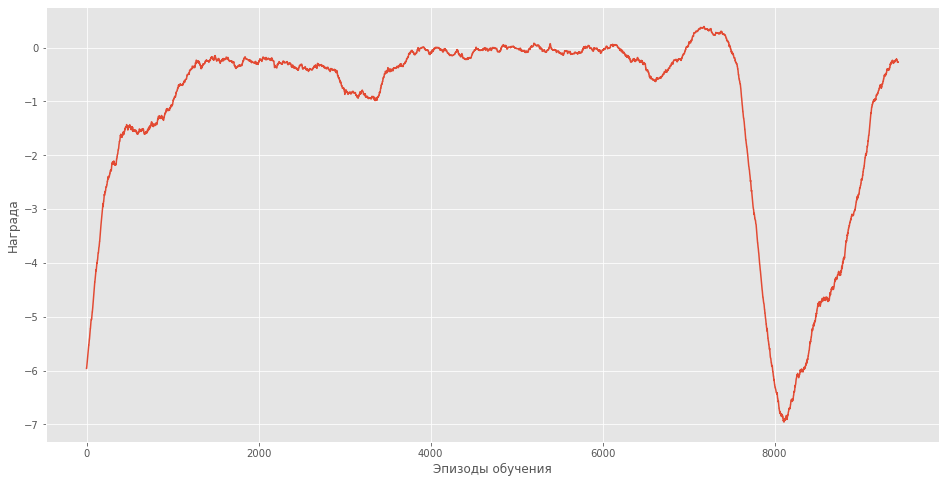

Средняя награда -1.2603904598973534


In [22]:
env = TicTacToeDuelingDQN(3)
for _ in tqdm(range(10000)):
    env.learn_model()

plt.figure(figsize=(16, 8))
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.plot(np.mean(rolling_window(np.array(env.rewards), 500), 1))
plt.show()
print("Средняя награда", np.mean(env.rewards))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:34<00:00, 46.55it/s]


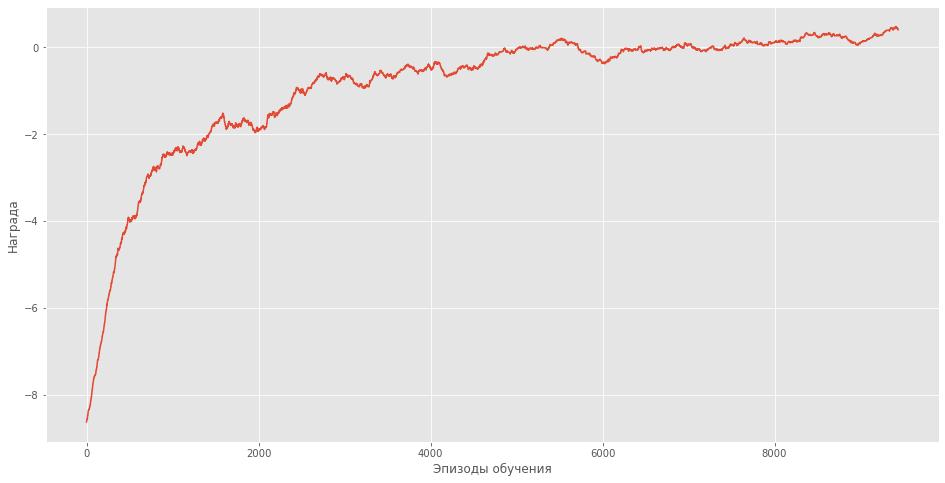

Средняя награда -1.0716514038442186


In [23]:
env = TicTacToeDuelingDQN(4)
for _ in tqdm(range(10000)):
    env.learn_model()

plt.figure(figsize=(16, 8))
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.plot(np.mean(rolling_window(np.array(env.rewards), 500), 1))
plt.show()
print("Средняя награда", np.mean(env.rewards))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:45<00:00, 24.66it/s]


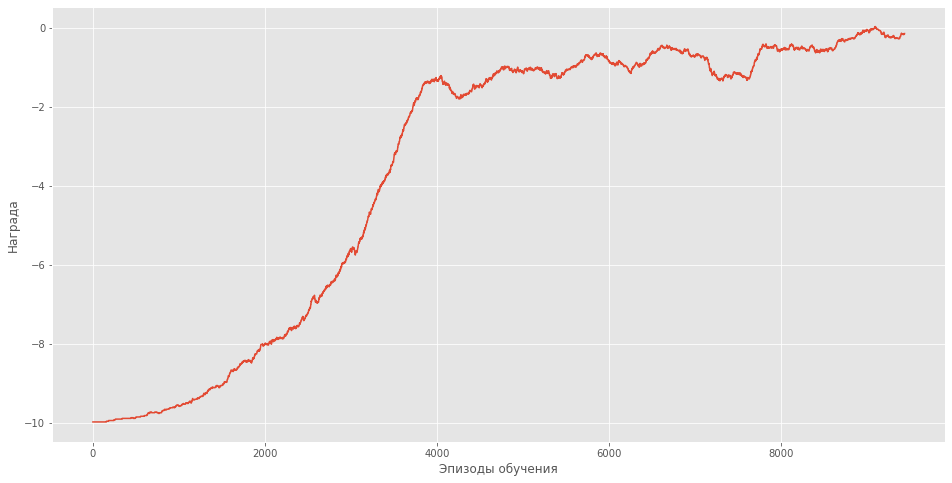

Средняя награда -3.631327362383013


In [24]:
env = TicTacToeDuelingDQN(5)
for _ in tqdm(range(10000)):
    env.learn_model()

plt.figure(figsize=(16, 8))
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.plot(np.mean(rolling_window(np.array(env.rewards), 500), 1))
plt.show()
print("Средняя награда", np.mean(env.rewards))

#### Вывод:

По графикам видно, что DuelingDQN обучается лучше, чем DQN, к сожалению не получилось достичь лучших результатов чем табличное обучение, возможно нужно добавить больше эпох.

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов:

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

#### Вывод: 

К сожалению не хватило времени реализовать остальные подходы